<a href="https://colab.research.google.com/github/pauletop/Deep-Learning-Subject/blob/main/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torchvision
import matplotlib.pyplot as plt
from torchvision import transforms

In [ ]:
train_dataset = torchvision.datasets.KMNIST(
    root="./data/KMNIST",
    train=True,
    transform=transforms.ToTensor(),
    download=True)

test_dataset = torchvision.datasets.KMNIST(
    root="./data/KMNIST",
    train=False,
    transform=transforms.ToTensor(),
    download=True)

100%|██████████| 18165135/18165135 [00:15<00:00, 1160401.58it/s]


Extracting ./data/KMNIST/KMNIST/raw/train-images-idx3-ubyte.gz to ./data/KMNIST/KMNIST/raw



100%|██████████| 29497/29497 [00:00<00:00, 186900.56it/s]


Extracting ./data/KMNIST/KMNIST/raw/train-labels-idx1-ubyte.gz to ./data/KMNIST/KMNIST/raw



100%|██████████| 3041136/3041136 [00:03<00:00, 867198.00it/s] 


Extracting ./data/KMNIST/KMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/KMNIST/KMNIST/raw



100%|██████████| 5120/5120 [00:00<00:00, 16368015.61it/s]


Extracting ./data/KMNIST/KMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/KMNIST/KMNIST/raw



In [ ]:
batch_size = 32


train_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2
)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2
)


In [ ]:
classes = ["o", "ki", "su", "tsu", "na", "ha", "ma", "ya", "re", "wo"]

labels_map = {
    0:"o",
    1:"ki",
    2:"su",
    3:"tsu",
    4:"na",
    5:"ha",
    6:"ma",
    7:"ya",
    8:"re",
    9:"wo"
}

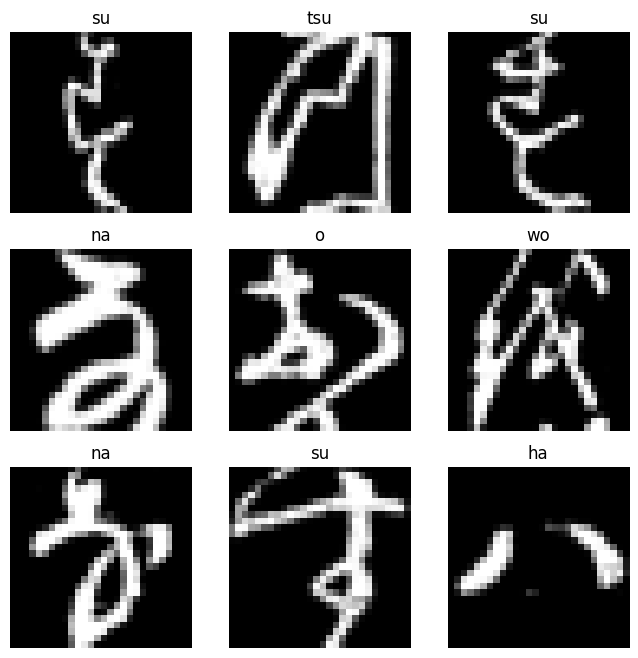

In [ ]:

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    # Lấy index ngẫu nhiên
    sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
    # Lấy dữ liệu ngẫu nhiên bằng index
    img, label = train_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    # Vẽ ảnh
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [ ]:
class CustomCNN(torch.nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()
        self.cnn_layers = torch.nn.Sequential(
            # Convolutional Layer. 64 filter
            torch.nn.Conv2d(1, 64, kernel_size=5, stride=1, padding="valid"),
            # Relu layer sau convolution
            torch.nn.ReLU(),
            torch.nn.Conv2d(64, 128, kernel_size=3, padding="valid"),
            torch.nn.ReLU(),
            # Bỏ bớt 10% output từ filter layer trước
            torch.nn.Dropout2d(0.1),
            # Max pooling 2x2
            torch.nn.MaxPool2d(2),
            torch.nn.Conv2d(128, 256, kernel_size=3, padding="valid"),
            torch.nn.ReLU(),
            torch.nn.Dropout2d(0.1),
            torch.nn.MaxPool2d(3),
            # Từ kết quả neuron phân bố 2D thành 1D
            torch.nn.Flatten(start_dim=1, end_dim=-1),
            # Bắt đầu layer Fully Connected của Neural Network bình thường
            # Số 2304 này được lấy bằng việc chạy thử CNN trước và xem lỗi cần số input neuron của layer là bao nhiêu. Có thể tự tính, nhưng phức tạp hơn. Có thể sử dụng nn.LazyLinear để không cần quan tâm đến số input neuron
            torch.nn.Linear(2304, 256),
            torch.nn.ReLU(),
            # Bỏ 10% neuron ngẫu nhiên.
            torch.nn.Dropout(0.1),
            torch.nn.Linear(256, 10),
            # Layer output dự đoán ảnh thuộc label nào
            torch.nn.Softmax()
        )

    def forward(self, X):
        # Giống với bài blog trước về Linear Regression
        # Chạy toàn bộ layer
        result = self.cnn_layers(X)
        return result

In [ ]:
cnn = CustomCNN()

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [ ]:
cnn = cnn.to(device)

In [ ]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=cnn.parameters(), lr=0.001, weight_decay=0.001)

In [ ]:
epochs = 4

for epoch in range(1, epochs + 1):
    correct = 0
    total_loss = 0
    # Từ Dataloader định nghĩa ở trên, ta sẽ lấy 32 ảnh và 32 labels.
    for X, y in train_dataloader:
        # Chuyển dữ liệu này cho GPU hoặc CPU
        # X là ảnh, y là label
        X = X.to(device)
        y = y.to(device)

        # Thử đưa 32 ảnh cho model CNN để dự đoán
        # Kết quả là cho mỗi ảnh có 10 xác xuất (tương ứng với 10 labels), xác xuất càng cao thì model càng chắc chắn về dự đoán
        pred_y = cnn(X)
        # Tính Cross Entropy Loss dựa vào độ sai lệch giữa dự đoán và label thật.
        loss = loss_fn(pred_y, y)

        # Phải cố tình cho gradient về 0, nếu không gradient sẽ tích trữ và học sai
        optimizer.zero_grad()
        # Back propagation: model tìm gradient để sửa lỗi
        loss.backward()
        # Sửa lại lỗi bằng cách update lại weight với gradient
        optimizer.step()

        # Ta sử dụng argmax để lấy index của chữ cái nào có xác xuất lớn nhất trong 10 chữ cái
        processed_pred_y = torch.argmax(pred_y, dim=1)
        correct += (processed_pred_y == y).float().sum()

    total_loss += loss
    # Tính độ chính xác của dự đoán so với label thực tế
    accuracy = 100 * correct / len(train_dataset)
    # In loss và độ chính xác cho mỗi epoch
    print(f"Epoch: {epoch}, loss: {total_loss}, accuracy: {accuracy:.2f}%")

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch: 1, loss: 1.542388677597046, accuracy: 80.12%


In [ ]:
def test(dataloader, model):
    correct_preds = 0
    total = 0
    for batch_index, (X, y) in enumerate(dataloader):
        # Chuyển dữ liệu ảnh và label đến GPU hoặc CPU
        X = X.to(device)
        y = y.to(device)
        # Cho model dự đoán
        predictions = model(X)
        processed_preds = torch.argmax(predictions, dim=1)
        correct_preds += torch.sum(processed_preds==y).item()
        total += X.shape[0]

    accuracy = correct_preds/total
    print(f"{accuracy*100:.5f}%")